In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [3]:
az.style.use("arviz-whitegrid")
plt.rc('figure', dpi=450)

In [2]:
tips = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data//tips.csv")
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


Text(0, 0.5, 'Day')

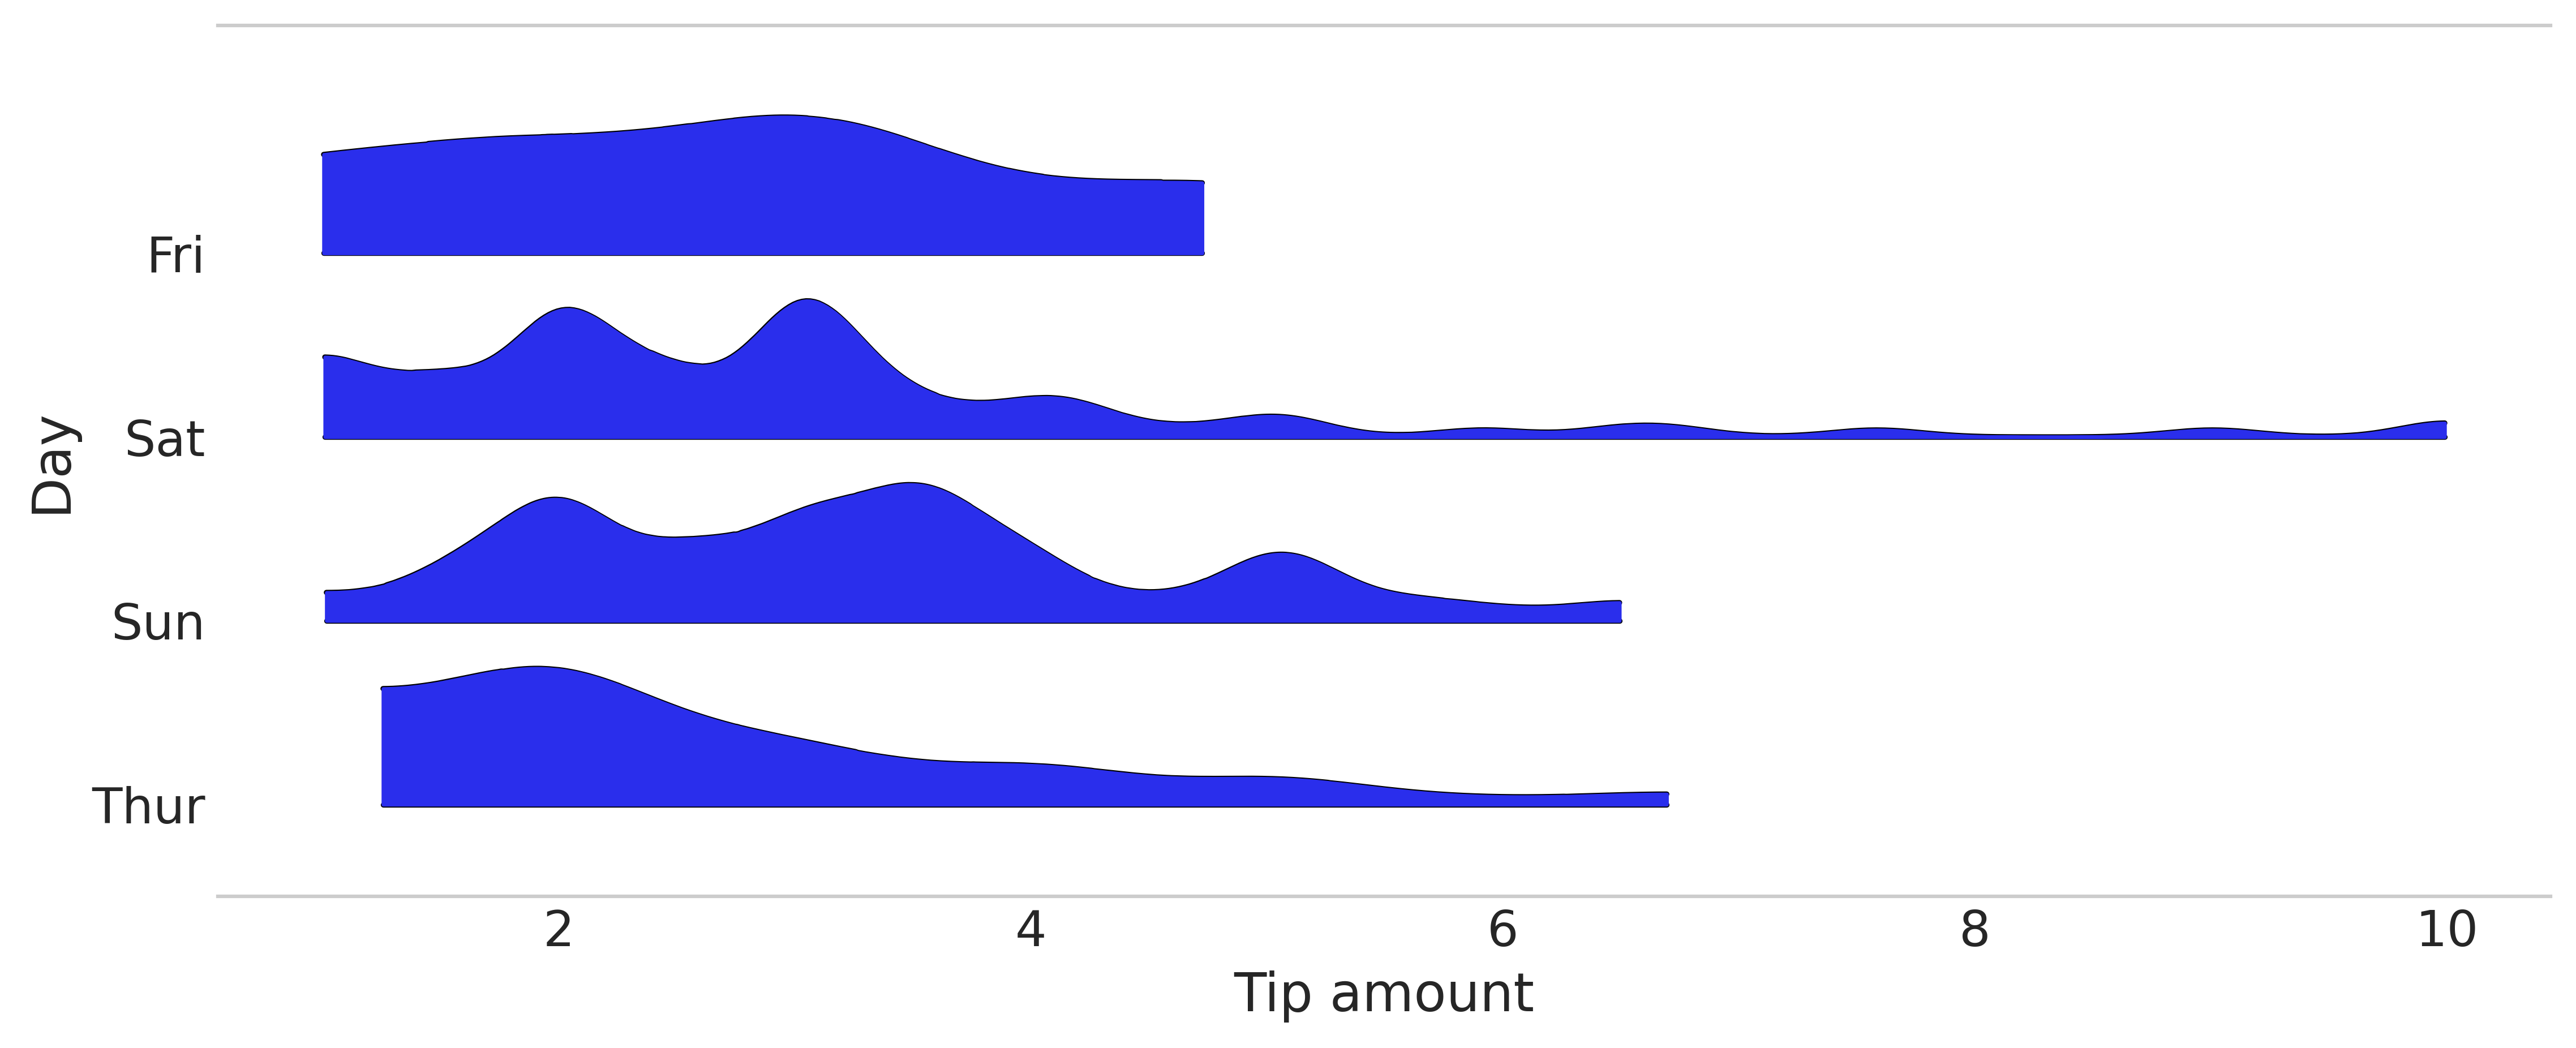

In [4]:
_, ax = plt.subplots(figsize=(10, 4))
az.plot_forest(tips.pivot(columns="day", values="tip").to_dict("list"),
               kind="ridgeplot",
               hdi_prob=1,
               ax=ax)
ax.set_xlabel("Tip amount")
ax.set_ylabel("Day")

In [5]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [7]:
pooled_coords = {"data": np.arange(len(tip))}


with pm.Model(coords=pooled_coords) as pooled_model:
    μ = pm.HalfNormal("μ", sigma=5)
    σ = pm.HalfNormal("σ", sigma=1)

    y = pm.Gamma("y", mu=μ, sigma=σ, observed=tip, dims="data")


unpooled_coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=unpooled_coords) as unpooled_model:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

models = {"pooled": pooled_model, "unpooled": unpooled_model}

In [8]:
idatas = {}
for model_name, model in models.items():
    with model:
        idata = pm.sample(2000, tune=1000)
        pm.sample_posterior_predictive(idata, extend_inferencedata=True)
        idatas[model_name] = idata



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.
Sampling: [y]


Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.
Sampling: [y]


Output()

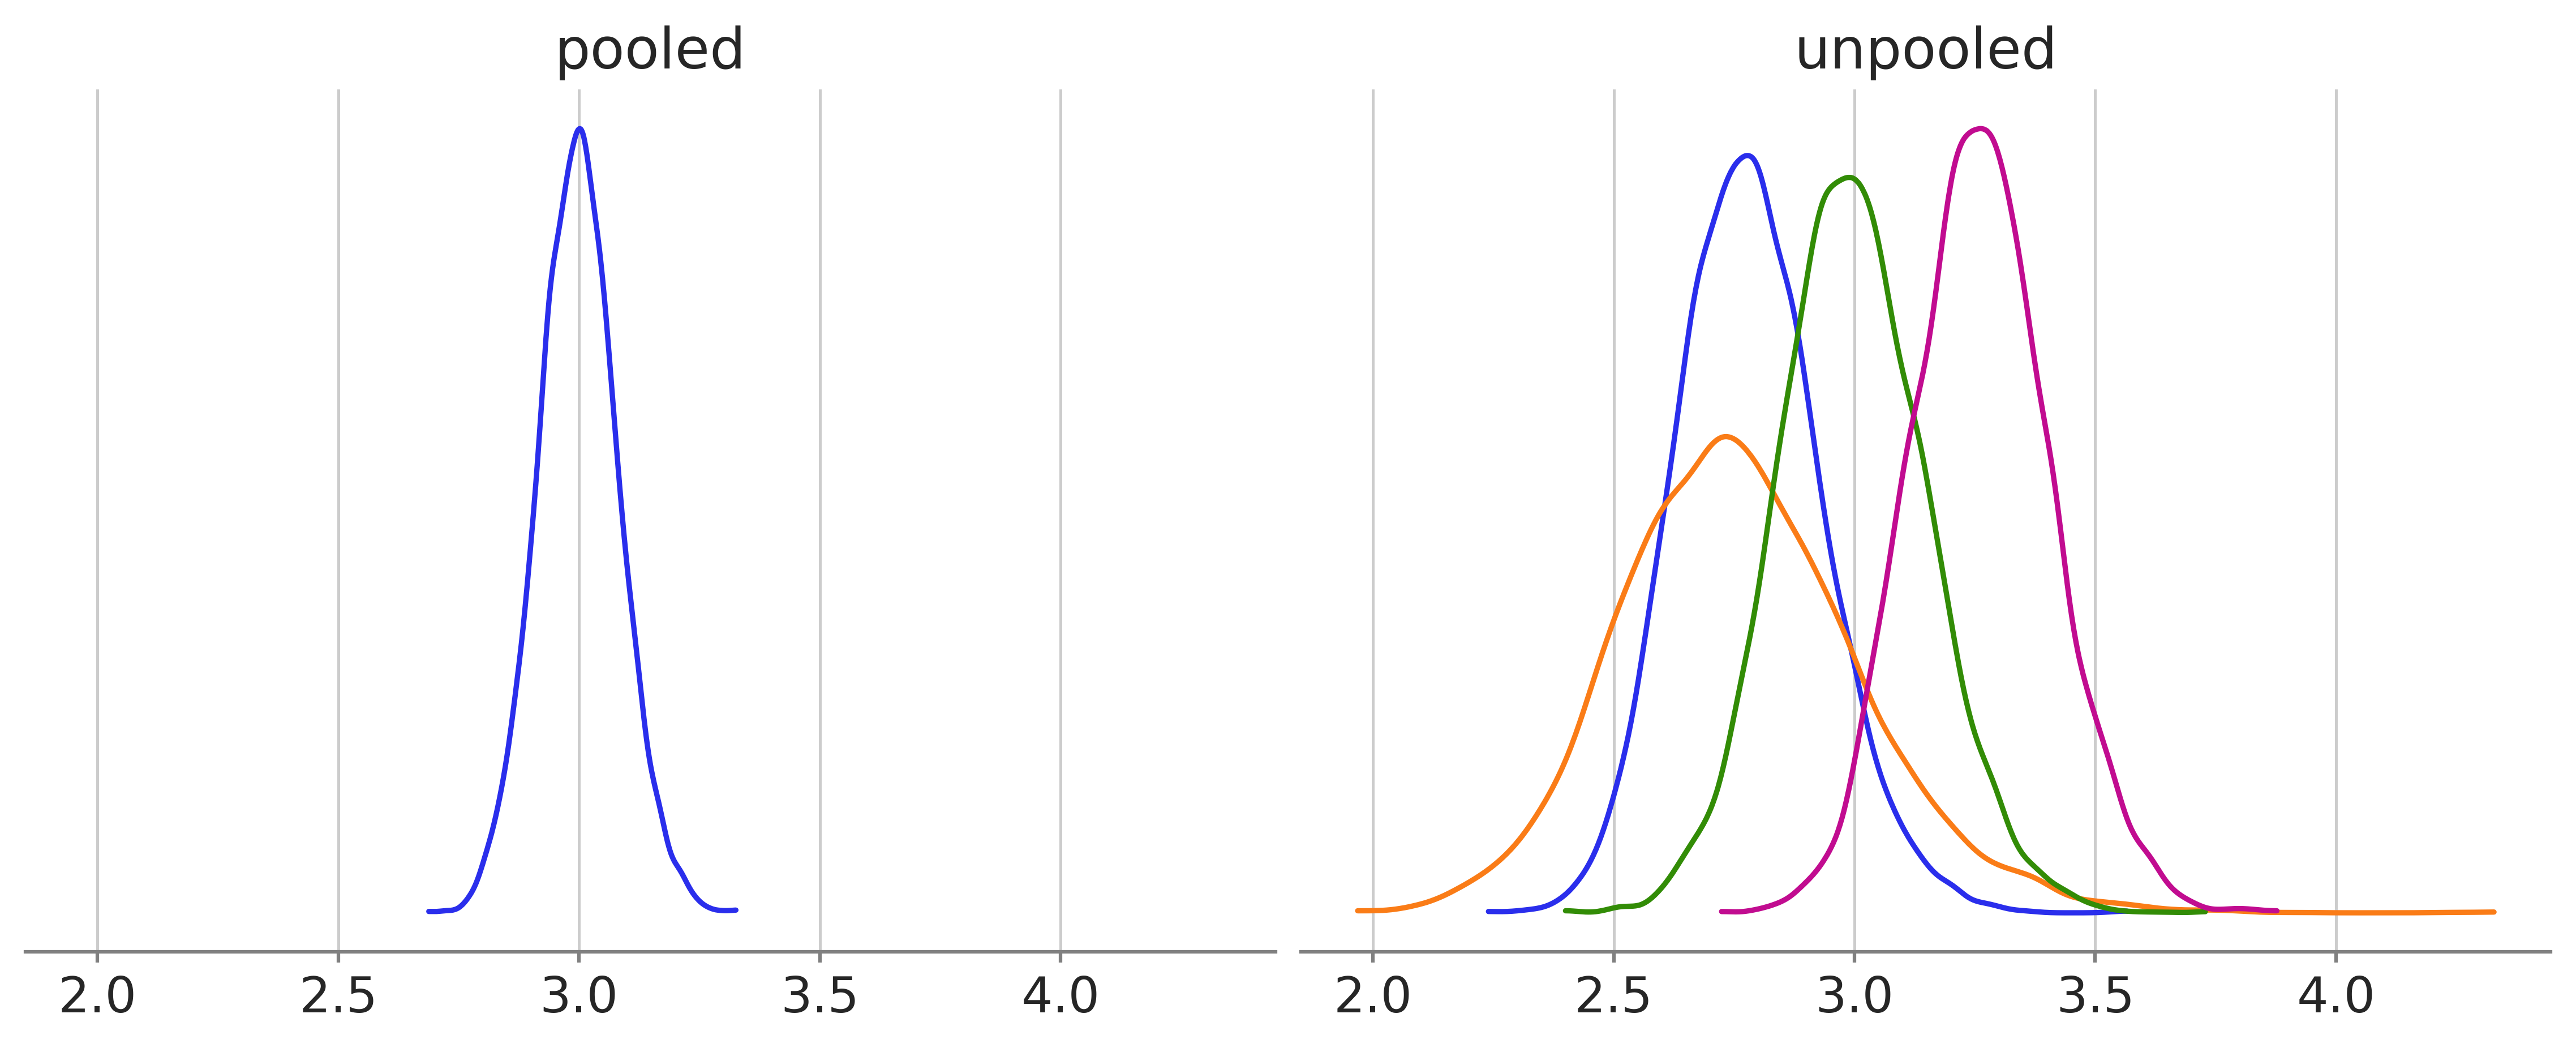

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for i, (model_name, idata) in enumerate(idatas.items()):
    if model_name == "pooled":
        pm.plot_posterior(idata, var_names=["μ", "σ"], ax=ax[i], hdi_prob='hide', point_estimate=None)
    else:
        for j,day in enumerate(categories):
            pm.plot_posterior(idata, var_names=["μ", "σ"], color=f"C{j}", coords={"days": day}, ax=ax[i], hdi_prob='hide', point_estimate=None)
    ax[i].set_title(model_name)
plt.show()
